Here I decided to play with my own implementation of different function for template matching.

Of course I can't match video frames at it works too slow but I provided examples on frames.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from IPython import display
import PIL.Image

In [2]:
def cv2_imshow(a):
    """A replacement for cv2.imshow() for use in Jupyter notebooks.
    Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
      (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
        image.
    """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display.display(PIL.Image.fromarray(a))

In [3]:
PATH = './template_matching/'

In [4]:
FRAME_FILE_TMP = '00{}.jpg'

template_rect = [336,165,26,61]    # grunt truth first rect

In [5]:
# function which generates gaussian kernel for 3 channels

def gaussian_kernel(kernel_sx, kernel_sy, sigma, channels = 3):
    
    shape = (kernel_sx, kernel_sy)
    
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[ -m : m + 1, -n : n + 1]
    h = np.exp( -(x * x + y * y) / (2. * sigma * sigma) )
    h[ h < np.finfo(h.dtype).eps * h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
        
    res = []
    
    for i in range(channels):
        res.append(h)
        
    return np.array(res).reshape(kernel_sx, kernel_sy,channels)

In [6]:
# function which takes matching function and frame numbers to compare

def template_match(method = 'ssd', img1='01', img2='02', normalize=False, apply_kernel=False):

    frame1 = cv2.imread(PATH + FRAME_FILE_TMP.format(img1))
    frame2 = cv2.imread(PATH + FRAME_FILE_TMP.format(img2))

    x, y, w, h = tuple(template_rect)
    height, width, _ = frame1.shape

    step = 1

    m_x, m_y = x, y
    min_func_val = np.infty

    frame1_copy = frame1.copy()
    frame2_copy = frame2.copy()
    
    # normalize images
    if normalize:
        frame1_copy = (frame1_copy - np.mean(frame1_copy))/np.var(frame1_copy)
        frame2_copy = (frame2_copy - np.mean(frame2_copy))/np.var(frame2_copy)

    f1 = frame1_copy[y:y+h, x:x+w]
    
    sigma = 10
    kernel = np.array(gaussian_kernel(h, w, sigma))
    
    f1 = f1.astype(float)
    
    if apply_kernel:
        f1 *= kernel

    for i in range(0, width - w, step):
        for j in range(0, height - h, step):
            f2 = frame2_copy[j:j+h, i:i+w].astype(float)
            
            if apply_kernel:
                f2 *= kernel

            if method == 'ssd':
                func_val = np.sum((f1 - f2)**2)
            elif method == 'ncc':
                func_val = -np.sum(f1 * f2)
            elif method == 'sad':
                func_val = np.sum(np.abs(f1 - f2))

            if func_val < min_func_val:
                min_func_val = func_val
                m_x, m_y = i, j


    print(m_x, m_y,min_func_val)


    print('\nFrame 1')
    cv2.rectangle(frame1, (x, y), (x+w,y+h), (255,0,0), 2)
    cv2_imshow(frame1)

    print('\nFrame 2')
    cv2.rectangle(frame2, (m_x, m_y), (m_x+w,m_y+h), (255,0,0), 2)
    cv2_imshow(frame2)


## 1) SSD function

This function matches well only for neighbor frames. If we take some other frames it matches to the background as it compares the squared difference between intensities. To improve this method perhaps we should apply some kernel to increase the weigths of central pixels.

I added an option to apply gaussian kernel to the matching frame. Let's comapre results with kernel.

335 165 6286003.0

Frame 1


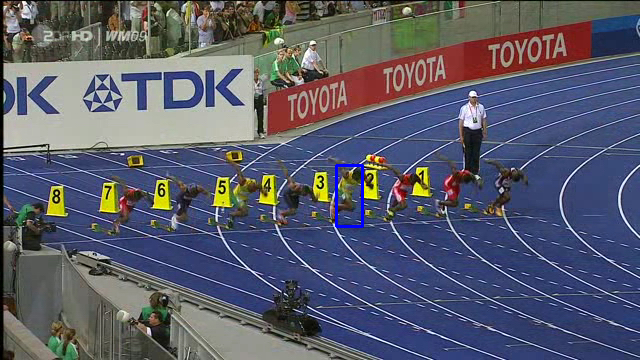


Frame 2


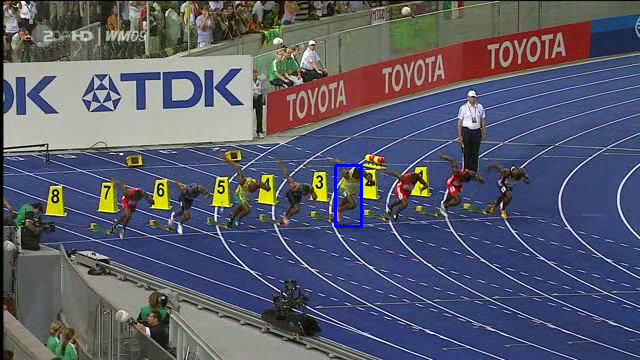

In [7]:
# SSD without gaussian kernel
template_match(method='ssd', img1='01', img2='02')

As we can see applying kernel weights allows us to detect at list a sportsman instead of background

16 257 7909195.0

Frame 1


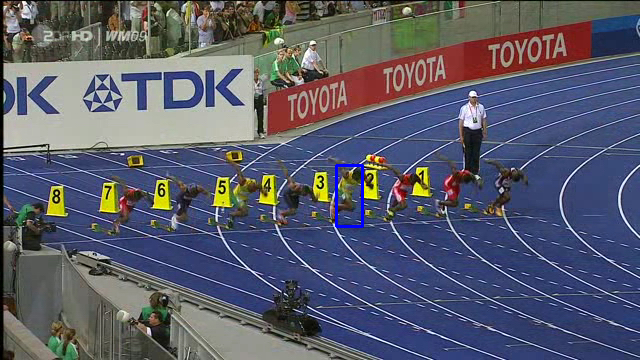


Frame 2


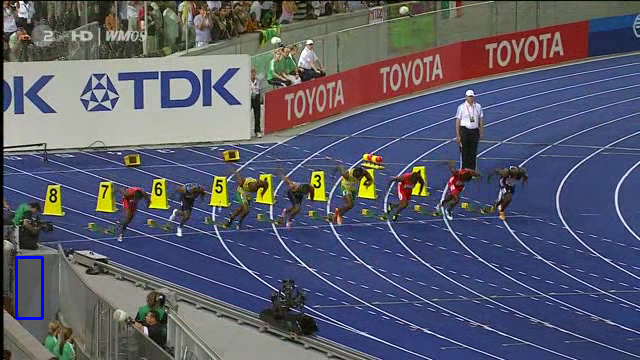

281 178 5.076171745431718

Frame 1


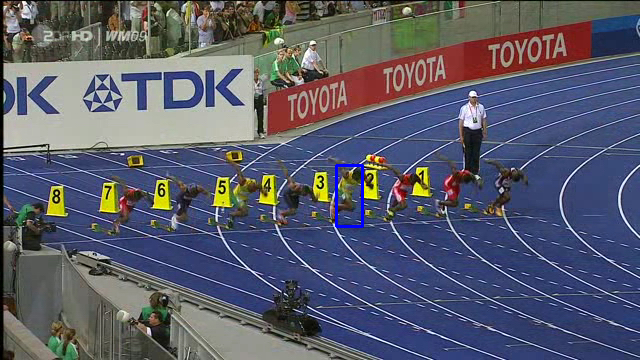


Frame 2


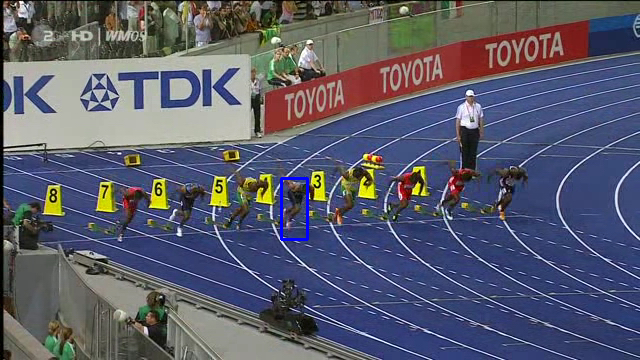

In [8]:
# SSD without gaussian kernel and with kernel
template_match(method='ssd', img1='01', img2='03')
template_match(method='ssd', img1='01', img2='03', apply_kernel=True)

## 2) SAD function

This function also matches well only for neighbor frames.

336 165 112888.0

Frame 1


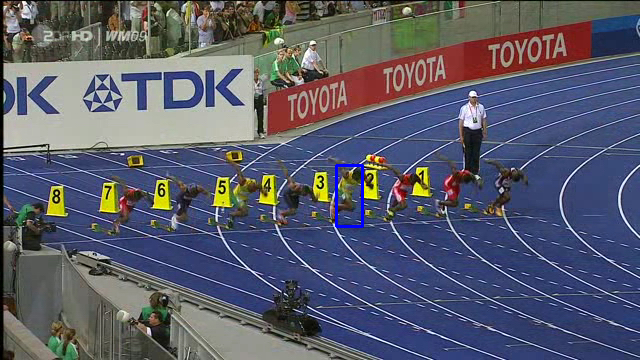


Frame 2


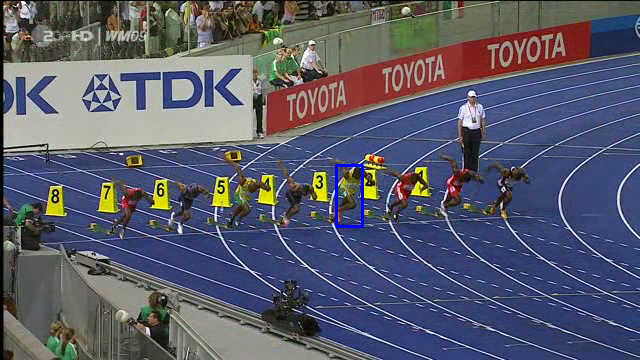

In [9]:
# SAD without gaussian kernel
template_match(method='sad', img1='01', img2='02')

232 173 145542.0

Frame 1


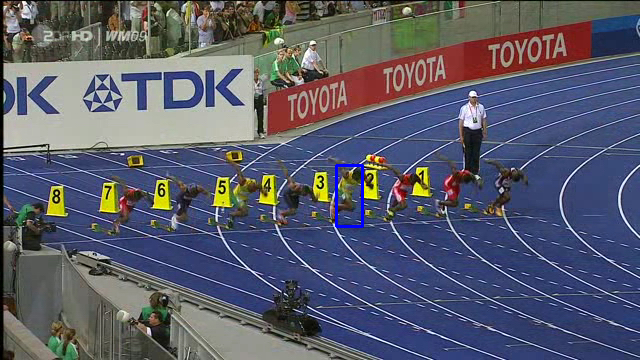


Frame 2


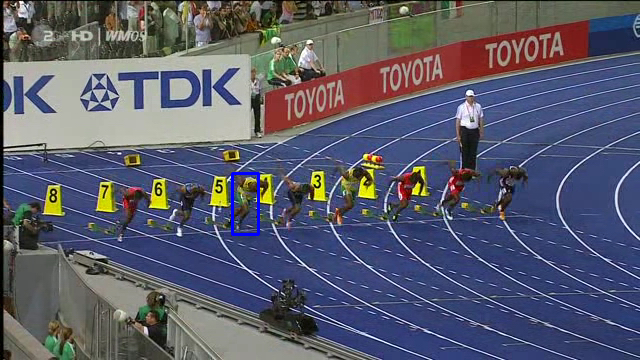

In [10]:
# detected other sportsman
template_match(method='sad', img1='01', img2='03')

282 179 86.21286630698845

Frame 1


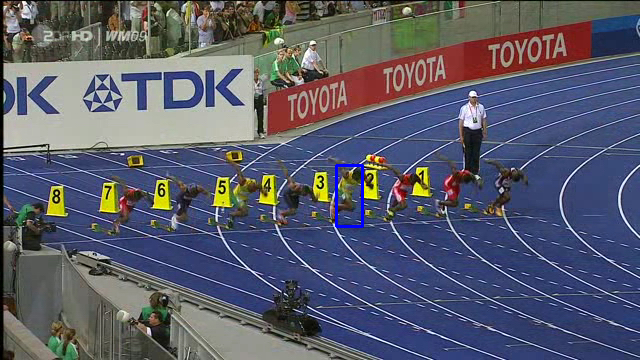


Frame 2


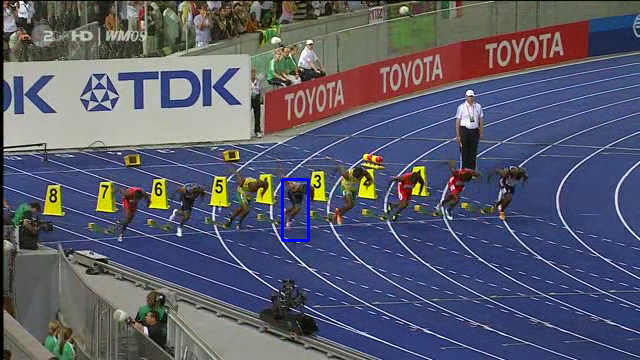

In [11]:
# the result is almost equal to result without kernel
template_match(method='sad', img1='01', img2='03', apply_kernel=True)

## 3) NCC function

NCC function shows the best result. It even matches 1st and 50th frames well. Asafa Powell is very similar to Usain Bolt :)

336 162 -0.842715001348194

Frame 1


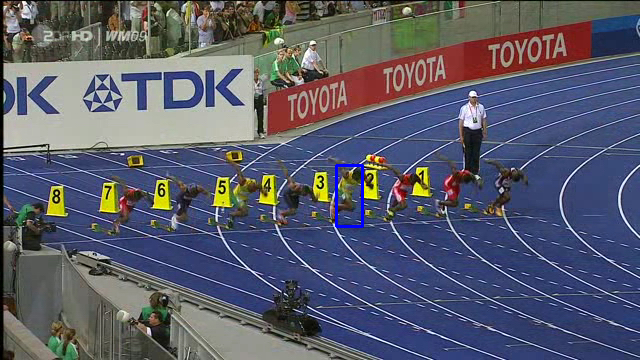


Frame 2


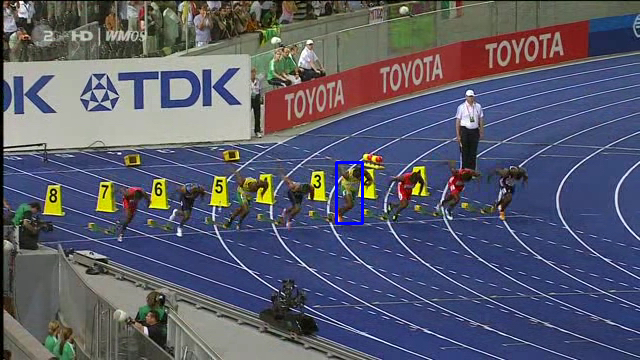

In [12]:
template_match(method='ncc', img1='01', img2='03', normalize=True)

233 165 -0.6475106017434333

Frame 1


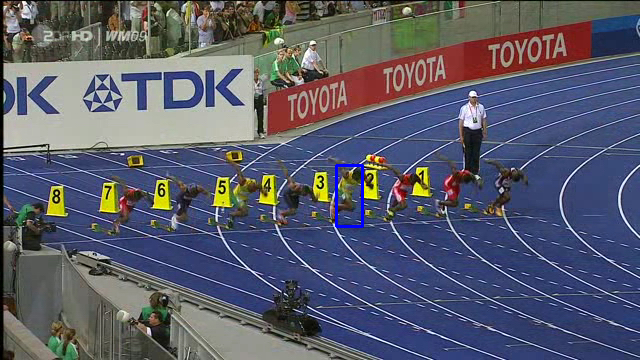


Frame 2


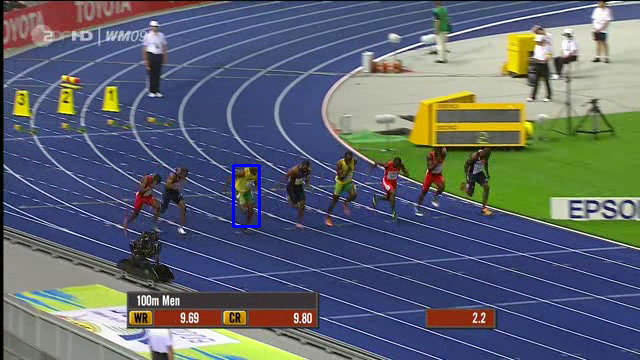

In [13]:
template_match(method='ncc', img1='01', img2='50', normalize=True)